In [2]:
import pandas as pd

In [3]:
import json
file_path = "user-wallet-transactions.json"      
with open(file_path, "r", encoding="utf‑8") as f:
    data = json.load(f)  

In [4]:
df = pd.json_normalize(data)

df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df['amount'] = df['actionData.amount'].astype(float)
df['assetPriceUSD'] = df['actionData.assetPriceUSD'].astype(float)
df['amount_usd'] = df['amount'] * df['assetPriceUSD']


In [5]:
wallet_features = df.groupby('userWallet').agg(
    tx_count=('action', 'count'),
    n_deposit=('action', lambda x: (x == 'deposit').sum()),
    n_borrow=('action', lambda x: (x == 'borrow').sum()),
    n_repay=('action', lambda x: (x == 'repay').sum()),
    n_liquidation=('action', lambda x: (x == 'liquidationcall').sum()),
    total_deposit_usd=('amount_usd', lambda x: x[df['action'] == 'deposit'].sum()),
    total_borrow_usd=('amount_usd', lambda x: x[df['action'] == 'borrow'].sum()),
    total_repay_usd=('amount_usd', lambda x: x[df['action'] == 'repay'].sum()),
    first_tx=('timestamp', 'min'),
    last_tx=('timestamp', 'max'),
)


In [6]:
wallet_features['active_days'] = (wallet_features['last_tx'] - wallet_features['first_tx']).dt.days + 1
wallet_features['repay_to_borrow'] = wallet_features['total_repay_usd'] / (wallet_features['total_borrow_usd'] + 1e-6)
wallet_features['liq_to_borrow'] = wallet_features['n_liquidation'] / (wallet_features['n_borrow'] + 1e-6)


In [7]:
def generate_score(row):
    score = 500 
    score += row['n_deposit'] * 3
    score += row['n_repay'] * 5
    score -= row['n_liquidation'] * 10
    score += row['repay_to_borrow'] * 100
    score -= row['liq_to_borrow'] * 50
    return min(max(score, 0), 1000)  

wallet_features['credit_score'] = wallet_features.apply(generate_score, axis=1)


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

features = [
    'n_deposit', 'total_deposit_usd', 'n_borrow', 'total_borrow_usd',
    'n_repay', 'total_repay_usd', 'n_liquidation',
    'repay_to_borrow', 'liq_to_borrow', 'active_days', 'tx_count'
]

X = wallet_features[features]
y = wallet_features['credit_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


C:\Users\JIJO\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


RandomForestRegressor(random_state=42)

In [9]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:",mean_squared_error(y_test, y_pred))


MAE: 4.243049812916441
MSE: 222.83237548552344


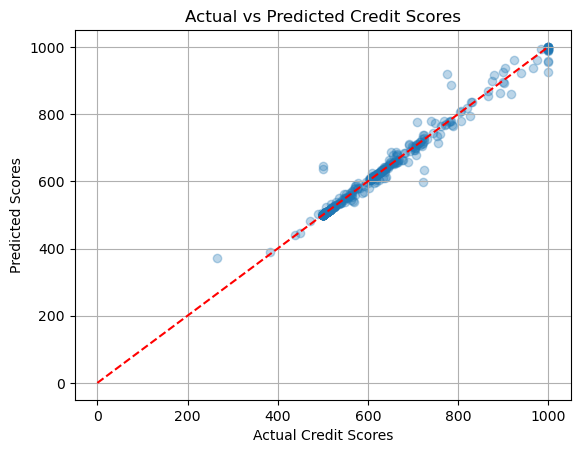

In [10]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual Credit Scores")
plt.ylabel("Predicted Scores")
plt.title("Actual vs Predicted Credit Scores")
plt.plot([0, 1000], [0, 1000], 'r--')
plt.grid(True)
plt.show()


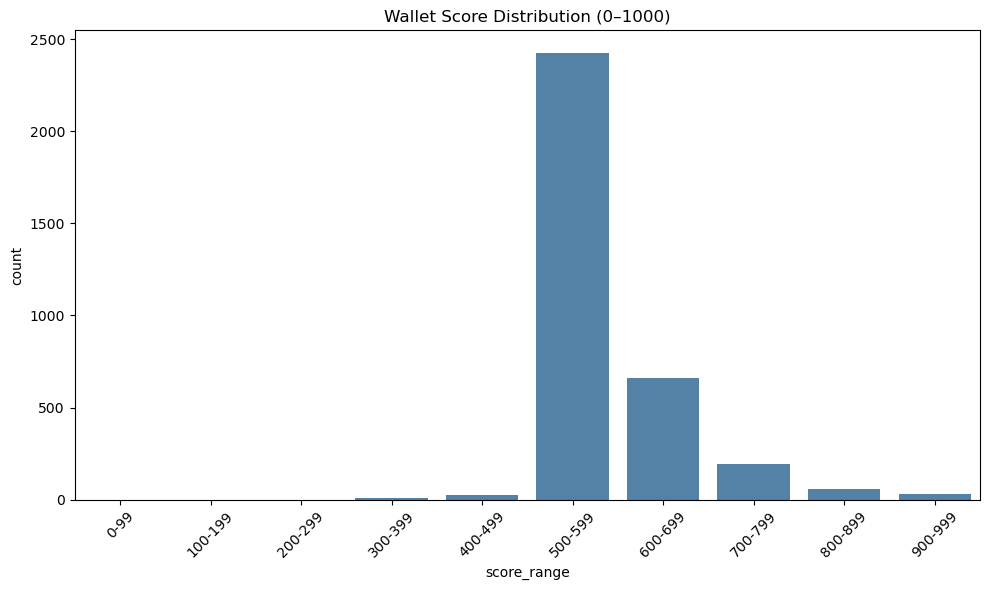

In [11]:
import seaborn as sns
wallet_features["score_range"] = pd.cut(wallet_features["credit_score"], bins=range(0,1100,100),
                           labels=[f"{i}-{i+99}" for i in range(0,1000,100)], right=False)
plt.figure(figsize=(10,6))
sns.countplot(x="score_range", data=wallet_features, color="steelblue")
plt.xticks(rotation=45)
plt.title("Wallet Score Distribution (0–1000)")
plt.tight_layout()
plt.show()


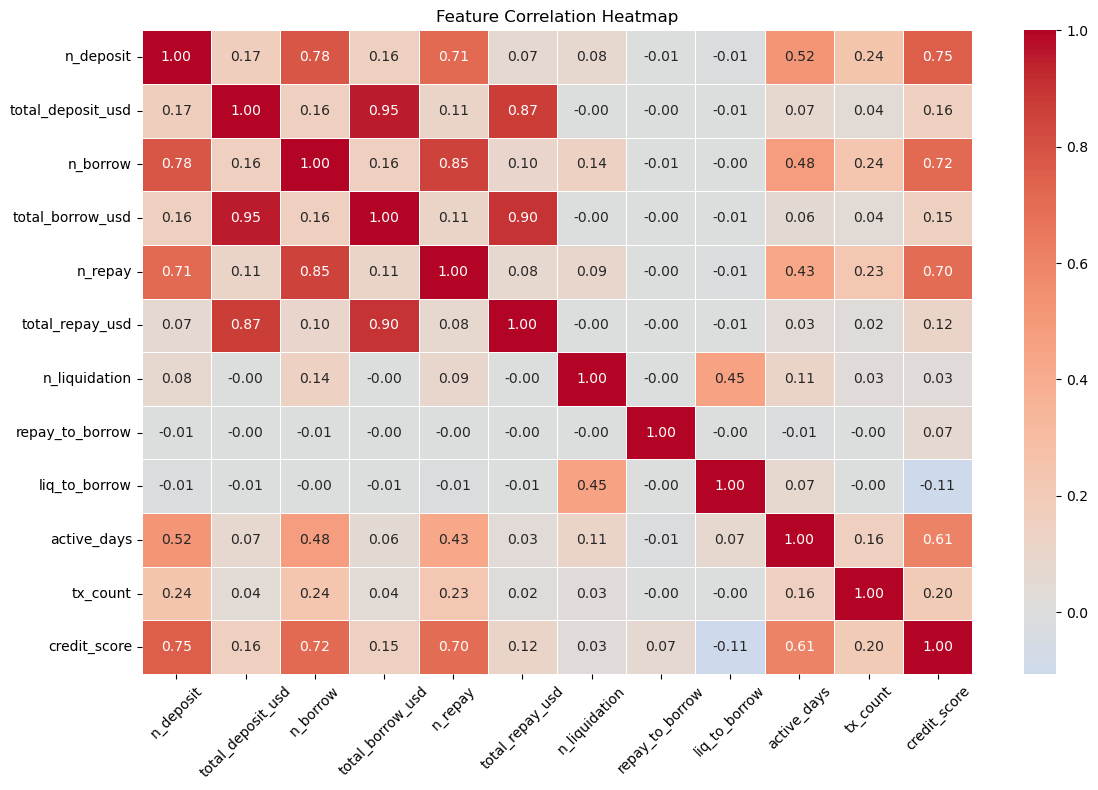

In [12]:
correlation_df = wallet_features[features + ['credit_score']]
corr_matrix = correlation_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
